In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *

## Boundary

In [2]:
nf = 18
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

boundary_points = pd.DataFrame(Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

## Interior

In [23]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = 289
t0, te = 0, 1.
N = 200
timegrid = np.linspace(0, 1)  # np.linspace(t0,te, N)

uh = assembled_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='MQ')
X0 = uh.X_0()

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

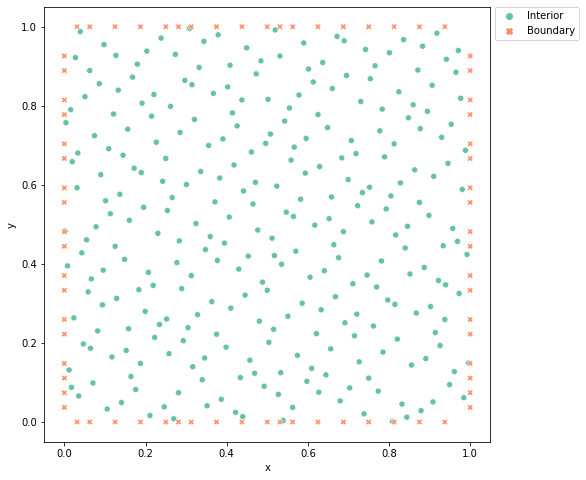

In [24]:
points = pd.concat([interior_points, boundary_points])
plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation', style='Collocation', palette='Set2')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [5]:
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [6]:
exp_RK.solve()

d:\projects\MSc Thesis\expressions.py:265: RuntimeWarning: overflow encountered in matmul
  return np.matmul(self.nu * self.lap_am().T - np.matmul(self.mu * self.a_m().T, np.matmul(X0, self.grad_am().T)), X0)
d:\projects\MSc Thesis\expressions.py:265: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(self.nu * self.lap_am().T - np.matmul(self.mu * self.a_m().T, np.matmul(X0, self.grad_am().T)), X0)


In [10]:
exp_RK.solution[0]

array([[ 5.00000000e-01,  5.30287619e-17],
       [-3.53553391e-01,  6.12372436e-01],
       [ 6.64463024e-01, -2.41844763e-01],
       [ 6.64522807e-02,  9.09843726e-01],
       [-7.07732782e-01, -2.45984169e-01],
       [ 7.07732782e-01,  2.45984169e-01],
       [-6.64522807e-02, -9.09843726e-01]])

In [9]:
def plot_solution(M, Mi, i):
    n = int(M.shape[0]/Mi.shape[0])
    df_i = pd.DataFrame()
    for ind in range(n):
        df_i = pd.concat([df_i, pd.DataFrame(Mi, columns=['x', 'y'])])
    df_i = df_i.reset_index().rename(columns={'index': 'i'})
    df = pd.DataFrame(M, columns=['u', 'v', 't'])
    df = pd.concat([df_i, df], axis=1)
    dff = df.loc[df['i'] == i]
    plt.figure(figsize=(8, 8))
    sns.lineplot(x='t', y='v', data=dff)
    return df

def u(Mi, norm_x, t, alpha=1):
    return Mi/((t+alpha) + (t+alpha)**2 * np.exp(norm_x**2/(4*(alpha +t))))

## Exact solution

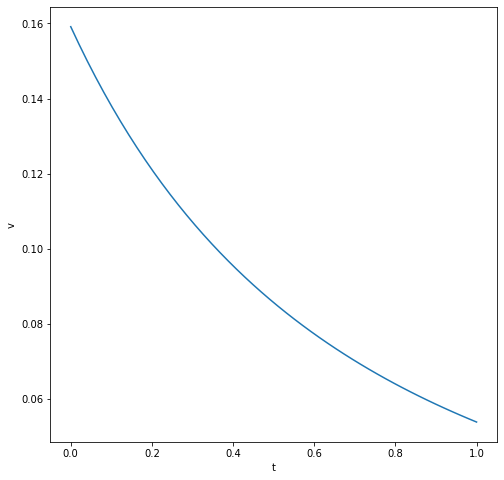

In [10]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ni = uh.Mi.shape[0]
u0= u(uh.Mi, norm_x, 0.)
u0 = np.hstack((u0, np.array([0.]*ni).reshape(-1,1)))
for t in timegrid[1:]:
    ui= u(uh.Mi, norm_x, t)
    ui = np.hstack((ui, np.array([t]*ni).reshape(-1,1)))
    u0 = np.vstack((u0, ui))

exact_sol = plot_solution(u0, uh.Mi, 0)

In [12]:
np.arange(0, 1, 0.025).reshape(-1,1)

array([[0.   ],
       [0.025],
       [0.05 ],
       [0.075],
       [0.1  ],
       [0.125],
       [0.15 ],
       [0.175],
       [0.2  ],
       [0.225],
       [0.25 ],
       [0.275],
       [0.3  ],
       [0.325],
       [0.35 ],
       [0.375],
       [0.4  ],
       [0.425],
       [0.45 ],
       [0.475],
       [0.5  ],
       [0.525],
       [0.55 ],
       [0.575],
       [0.6  ],
       [0.625],
       [0.65 ],
       [0.675],
       [0.7  ],
       [0.725],
       [0.75 ],
       [0.775],
       [0.8  ],
       [0.825],
       [0.85 ],
       [0.875],
       [0.9  ],
       [0.925],
       [0.95 ],
       [0.975]])

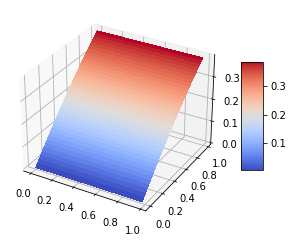

In [22]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
n_X = np.linalg.norm(np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), axis=1).reshape(-1,1)
X, Y = np.meshgrid(X, Y)
t=0.05
V = Y/((1+t) + (1+t)*np.exp(n_X/(4*(1+t))))

# Plot the surface.
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
ti = exact_sol.t.unique()[5]
sol_i = exact_sol[exact_sol['t'] == ti][['u', 'v']].values

In [ ]:
app_u_i = X0 + ti*Fm(X0, uh)
np.mean(abs(sol_i- app_u_i)[:,0])

## Solution

In [ ]:
sol = FDM_time(timegrid, X0, uh)
for t, s in sol.items():
    print('Time: {:,.4f}'.format(t))
    print(s, '\n')